In [1]:
import numpy
from astropy import units
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.df import streamdf
from galpy.util import bovy_coords, bovy_conversion
from galpy.df.streamgapdf import _rotate_to_arbitrary_vector
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import streamspraydf
from importlib import reload
reload(streamspraydf)

<module 'streamspraydf' from '/Users/bovy/Repos/effect_of_bar/streamspraydf.py'>

# Example of Fardal et al. (2015) stream-spray method

Using the same orbit, potential, and cluster mass as in [Bovy (2014)](http://adsabs.harvard.edu/abs/2014ApJ...795...95B):

In [3]:
o= Orbit([1.56148083,0.35081535,-1.15481504,0.88719443,-0.47713334,0.12019596])
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)

In [4]:
spdf= streamspraydf.streamspraydf(2*10.**4.*units.Msun,progenitor=o,pot=lp,tdisrupt=4.5*units.Gyr)
spdft= streamspraydf.streamspraydf(2*10.**4.*units.Msun,progenitor=o,pot=lp,leading=False,tdisrupt=4.5*units.Gyr)

First, let's check that the integration is working. We generate a set of stars that is sitting just outside the progenitor:

In [5]:
numpy.random.seed(4)
RvR_noint,dt_noint= spdf.sample(n=100,returndt=True,integrate=False)
RvRt_noint,dtt_noint= spdft.sample(n=100,returndt=True,integrate=False)

Now we generate the same sample of stars (by setting the random seed to the same value), but have the code integrate them forward:

In [6]:
numpy.random.seed(4)
RvR,dt= spdf.sample(n=100,returndt=True,integrate=True)
RvRt,dt= spdft.sample(n=100,returndt=True,integrate=True)

Let's now integrate the 'not-integrated' set by hand:

In [7]:
# Leading
for ii in range(len(dt_noint)):
    to= Orbit(RvR_noint[:,ii])
    to.integrate(numpy.linspace(-dt_noint[ii],0.,1001),lp)
    RvR_noint[:,ii]= [to.R(0.),to.vR(0.),to.vT(0.),to.z(0.),to.vz(0.),to.phi(0.)]
# Trailing
for ii in range(len(dtt_noint)):
    to= Orbit(RvRt_noint[:,ii])
    to.integrate(numpy.linspace(-dtt_noint[ii],0.,1001),lp)
    RvRt_noint[:,ii]= [to.R(0.),to.vR(0.),to.vT(0.),to.z(0.),to.vz(0.),to.phi(0.)]

Compare them one-to-one

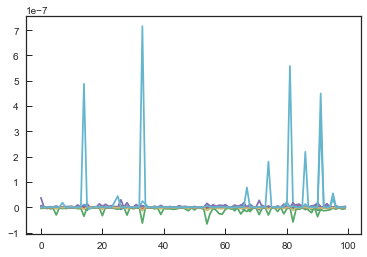

In [8]:
plot(((RvR_noint-RvR)/RvR).T);
plot(((RvRt_noint-RvRt)/RvR).T);

Very small differences, consistent with integration errors. Now let's look at the stream! First we integrate the progenitor forward and backward for a short time, so we can show its path. We also setup ``galpy.df.streamdf`` objects which model the same track with a frequency-angle framework:

In [9]:
ts= numpy.linspace(0.,3.,301)
o.integrate(ts,lp)
of= o()
of.integrate(-ts,lp)

In [10]:
aAIA= actionAngleIsochroneApprox(b=0.8,pot=lp)
sigv= 0.365 #km/s
sdf= streamdf(sigv/220.,progenitor=o(),pot=lp,aA=aAIA,leading=True,
              nTrackChunks=11,tdisrupt=4.5*units.Gyr)
sdft= streamdf(sigv/220.,progenitor=o(),pot=lp,aA=aAIA,leading=False,
               nTrackChunks=11,tdisrupt=4.5*units.Gyr)

In [11]:
# Sample again to get more stars
RvR,dt= spdf.sample(n=300,returndt=True,integrate=True)
RvRt,dt= spdft.sample(n=300,returndt=True,integrate=True)

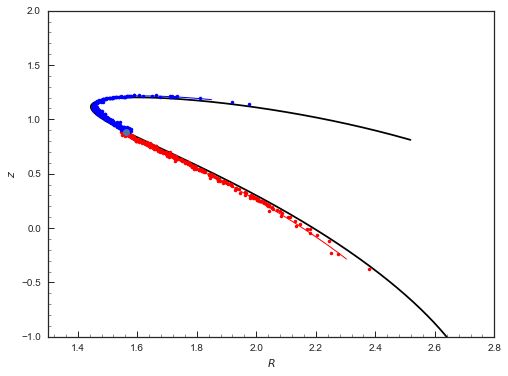

In [12]:
figsize(8,6)
o.plot(color='k',xrange=[1.3,2.8],yrange=[-1.,2.])
of.plot(overplot=True,color='k')
plot(RvR[0],RvR[3],'r.')
plot(RvRt[0],RvRt[3],'b.')
sdf.plotTrack(d1='R',d2='z',interp=True,color='r',overplot=True,lw=1.)
sdft.plotTrack(d1='R',d2='z',interp=True,color='b',overplot=True,lw=1.)
plot(o.R(),o.z(),'o');

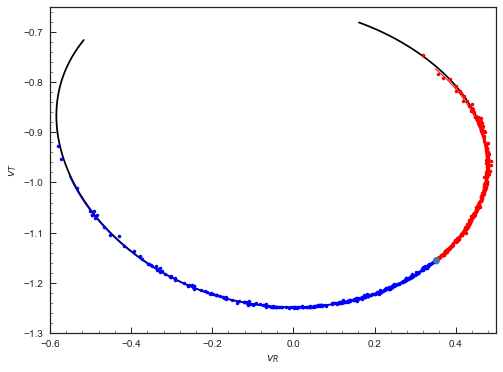

In [13]:
o.plot(d1='vR',d2='vT',color='k',xrange=[-0.6,0.5],yrange=[-1.3,-0.65])
of.plot(d1='vR',d2='vT',overplot=True,color='k')
plot(RvR[1],RvR[2],'r.')
plot(RvRt[1],RvRt[2],'b.')
sdf.plotTrack(d1='vR',d2='vT',interp=True,color='r',overplot=True,lw=1.)
sdft.plotTrack(d1='vR',d2='vT',interp=True,color='b',overplot=True,lw=1.)
plot(o.vR(),o.vT(),'o');

These match remarkably well! Let's take a look at the action-angle coordinates for this stream:

In [14]:
jrp,jpp,jzp,Orp,Opp,Ozp,arp,app,azp= aAIA.actionsFreqsAngles(o())
jr,jp,jz,Or,Op,Oz,ar,ap,az= aAIA.actionsFreqsAngles(*RvR)
jrt,jpt,jzt,Ort,Opt,Ozt,art,apt,azt= aAIA.actionsFreqsAngles(*RvRt)
# Center angles around pi
ar=  (ar-arp+numpy.pi) % (2.*numpy.pi)
art= (art-arp+numpy.pi) % (2.*numpy.pi)
ap=  (ap-app+numpy.pi) % (2.*numpy.pi)
apt= (apt-app+numpy.pi) % (2.*numpy.pi)
az=  (az-azp+numpy.pi) % (2.*numpy.pi)
azt= (azt-azp+numpy.pi) % (2.*numpy.pi)

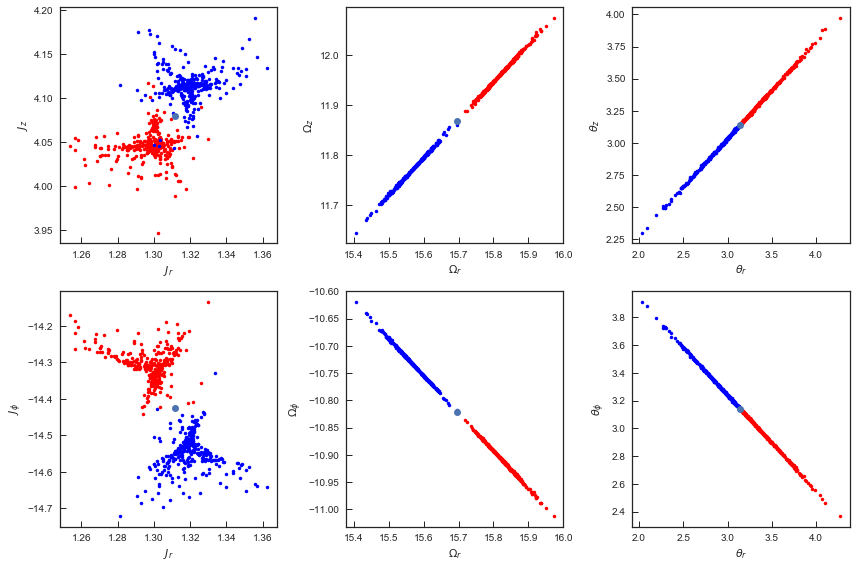

In [15]:
figsize(12,8)
actionsFac= 8.
freqFac= bovy_conversion.freq_in_Gyr(220.,8.)
subplot(2,3,1)
plot(jr*actionsFac,jz*actionsFac,'r.')
plot(jrt*actionsFac,jzt*actionsFac,'b.')
plot(jrp*actionsFac,jzp*actionsFac,'o')
xlabel(r'$J_r$'); ylabel(r'$J_z$')
subplot(2,3,2)
plot(Or*freqFac,Oz*freqFac,'r.')
plot(Ort*freqFac,Ozt*freqFac,'b.')
plot(Orp*freqFac,Ozp*freqFac,'o')
xlabel(r'$\Omega_r$'); ylabel(r'$\Omega_z$')
subplot(2,3,3)
plot(ar,az,'r.')
plot(art,azt,'b.')
plot(numpy.pi,numpy.pi,'o')
xlabel(r'$\theta_r$'); ylabel(r'$\theta_z$')
subplot(2,3,4)
plot(jr*actionsFac,jp*actionsFac,'r.')
plot(jrt*actionsFac,jpt*actionsFac,'b.')
plot(jrp*actionsFac,jpp*actionsFac,'o')
xlabel(r'$J_r$'); ylabel(r'$J_\phi$')
subplot(2,3,5)
plot(Or*freqFac,Op*freqFac,'r.')
plot(Ort*freqFac,Opt*freqFac,'b.')
plot(Orp*freqFac,Opp*freqFac,'o')
xlabel(r'$\Omega_r$'); ylabel(r'$\Omega_\phi$')
subplot(2,3,6)
plot(ar,ap,'r.')
plot(art,apt,'b.')
plot(numpy.pi,numpy.pi,'o')
xlabel(r'$\theta_r$'); ylabel(r'$\theta_\phi$')
tight_layout();

These look very similar to those in Bovy (2014)!